# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

**Objective:** This notebook provides a comprehensive analysis of the Yeast dataset to uncover data veracity challenges in multi-label classification. We will go beyond the required tasks by first performing an exploratory data analysis on the labels, then using t-SNE and Isomap for non-linear visualization, comparing them to a linear PCA baseline, and finally, bridging our visual findings with the performance of a real-world classifier to create a complete and compelling data story.

**Student:** Venkata Sai Vishwesvar SV
**Roll:** BE22B042

---

##Part A: Preprocessing and Initial Setup

In this section, we begin by loading the Yeast dataset and performing essential preliminary steps. These include verifying the dataset integrity, analyzing label distributions and their co-occurrences, generating a simplified target variable for visualization purposes, and scaling the input features for model readiness.

#1. Data Loading

We start by importing the required libraries. The scipy package is used to load the .arff dataset format, while pandas and numpy handle data manipulation. For machine learning tasks, we rely on sklearn, and for visualization, we employ matplotlib and seaborn.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.io import arff
from collections import Counter
import warnings

# Preprocessing, Dimensionality Reduction, and Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import ClassifierChain # A common strategy for multi-label problems

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style='whitegrid', context='notebook', rc={'figure.figsize':(14,10)})
warnings.filterwarnings('ignore')

The Yeast dataset is provided in an `.arff` file, which contains both the features and labels. We need to parse this file to separate the feature matrix `X` from the multi-label target matrix `Y`. The last 14 attributes in the file correspond to the labels.

In [ ]:
# Load the ARFF file
data, meta = arff.loadarff('yeast.arff')

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# The last 14 columns are the labels, and the first 103 are features.
# The label columns are loaded as bytes, so we need to decode and convert them to integers.
feature_names = meta.names()[:103]
label_names = meta.names()[103:]

X = df[feature_names].values
Y = df[label_names].apply(pd.to_numeric).values

print("Data loaded successfully.")

Data loaded successfully.


### 2. Dimensionality Check

Next, we verify the initial dimensions of our feature matrices and label matrices to understand the scale of our dataset.

In [ ]:
# Get the shape of the matrices
num_samples, num_features = X.shape
_, num_labels = Y.shape

print(f"Initial number of data points (samples): {num_samples}")
print(f"Initial number of features: {num_features}")
print(f"Number of labels: {num_labels}")

Initial number of data points (samples): 2417
Initial number of features: 103
Number of labels: 14


**Analysis:** The dataset consists of 2417 samples (gene experiments), each described by 103 features (gene expression levels). Each sample can be associated with one or more of the 14 possible functional categories (labels).

##3. Exploratory Data Analysis on Labels

Before diving into visualizations of the high-dimensional dataset, it’s important to first analyze the target labels. This step provides valuable context about the classification challenges we may encounter.

Label Frequency Distribution:
We begin by plotting the occurrence frequency of each of the 14 functional categories. This helps reveal potential class imbalances—an issue often encountered in multi-label classification tasks.

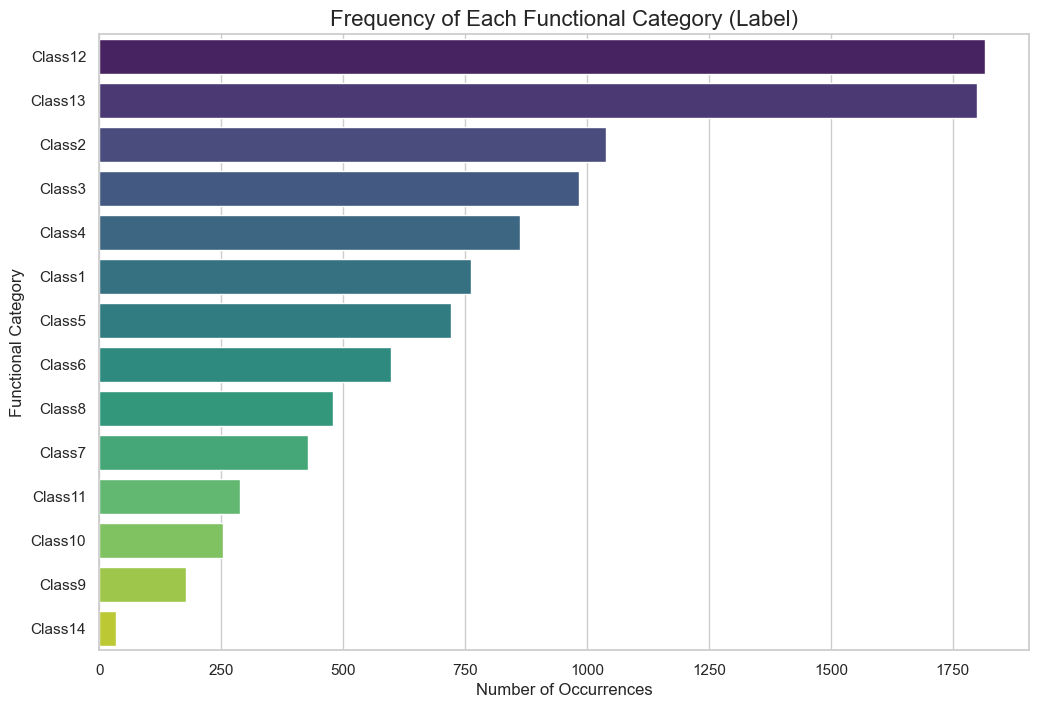

In [ ]:
label_counts = pd.DataFrame(Y, columns=label_names).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.title('Frequency of Each Functional Category (Label)', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Functional Category', fontsize=12)
plt.show()

**Analysis:**  
The bar plot highlights a noticeable imbalance across the label distributions. Certain categories (such as `class12` and `class3`) appear frequently, whereas others (like `class9` and `class14`) occur very rarely. Such imbalance poses a significant challenge for classifiers, as they may tend to favor the majority classes while underperforming on the minority ones.  

#### Label Co-occurrence Heatmap  

Next, we’ll visualize the co-occurrence of labels to examine how often different categories appear together. This step is key to understanding the multi-label structure of the dataset and identifying interrelated functional classes.


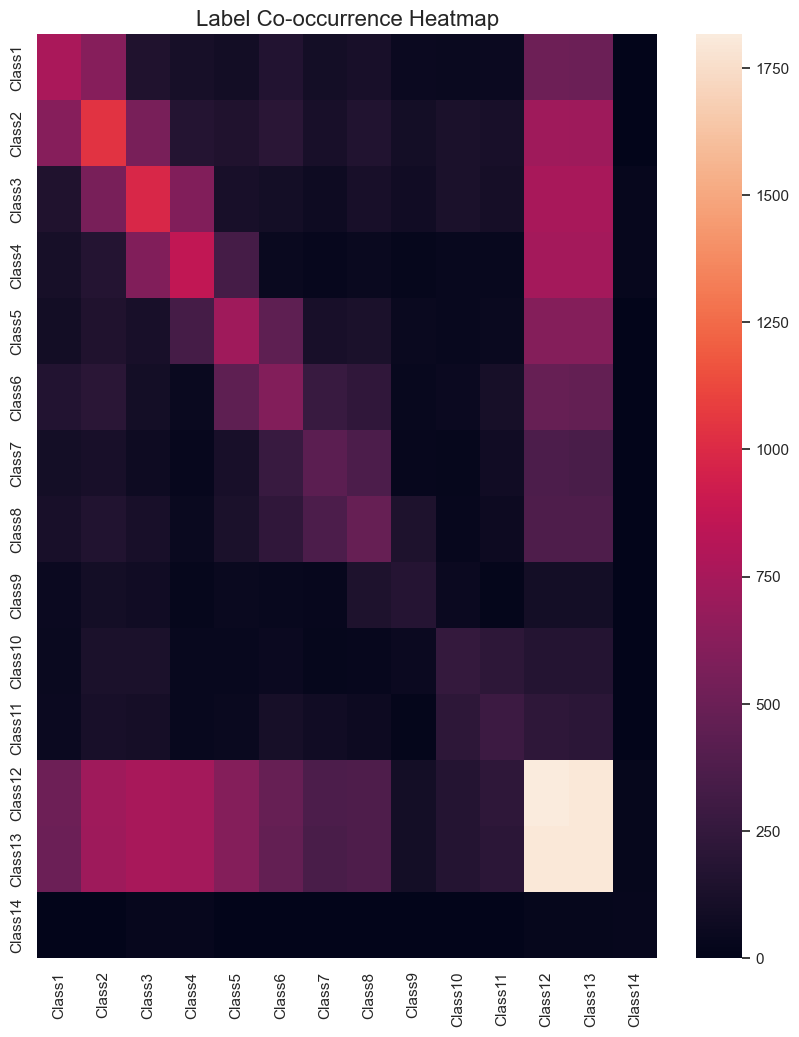

In [ ]:
# Compute the co-occurrence matrix
Y_df = pd.DataFrame(Y, columns=label_names)
co_occurrence_matrix = Y_df.T.dot(Y_df)

# Plot the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(co_occurrence_matrix, annot=False)
plt.title('Label Co-occurrence Heatmap', fontsize=16)
plt.show()

**Analysis: Untangling the Complexity**  

The heatmap provides deep insights into the underlying challenges of this classification task:  

*   **Bright Diagonal – Dominant Functions:**  
    The diagonal from top-left to bottom-right captures the frequency of each class. The nearly white square for `Class12` confirms it as the most prevalent function, while `Class2`, `Class3`, and `Class4` also appear relatively often. This clearly reflects the **strong class imbalance** present in the dataset.  

*   **Off-Diagonal Highlights – Functional Relationships:**  
    The brighter regions away from the diagonal indicate labels that frequently occur together. Notably, `Class2`, `Class3`, and `Class4` form a distinct co-occurrence cluster, suggesting potential biological linkage. The broad horizontal and vertical streaks associated with `Class12` further suggest it co-occurs with many other functions.  

*   **Takeaway – A Web of Overlaps:**  
    This is far from a straightforward classification task. A model must not only identify `Class12` but also distinguish between samples that are purely `Class12` and those that are both `Class12` and `Class4`. The high co-occurrence across labels introduces substantial **ambiguity** and creates **challenging, overlapping samples**—underscoring the need for advanced visualization techniques to explore how these interactions manifest in the feature space.





### 3. Label Selection for Visualization  

Visualizing data across 14 different labels can quickly become complex and cluttered. To make the visualizations more interpretable, we create a new categorical target variable that simplifies the label space for coloring our plots. This variable emphasizes the most significant groups in the dataset:  

1.  The two most frequent **single-label** categories.  
2.  The most common **multi-label combination**.  
3.  All remaining samples grouped under an **“Other”** category.  

This approach enables us to concentrate on the most prevalent and well-defined classes while still retaining awareness of the overall dataset diversity.


Most frequent single label is at index: 0 (Label: Class1)
Second most frequent single label is at index: 13 (Label: Class14)

Most frequent multi-label combination involves labels: ['Class3', 'Class4', 'Class12', 'Class13']

Value counts for the new visualization categories:
Visualization Category
Other                    2148
Top Multi-Label Combo     237
Top Single: Class1         32
Name: count, dtype: int64


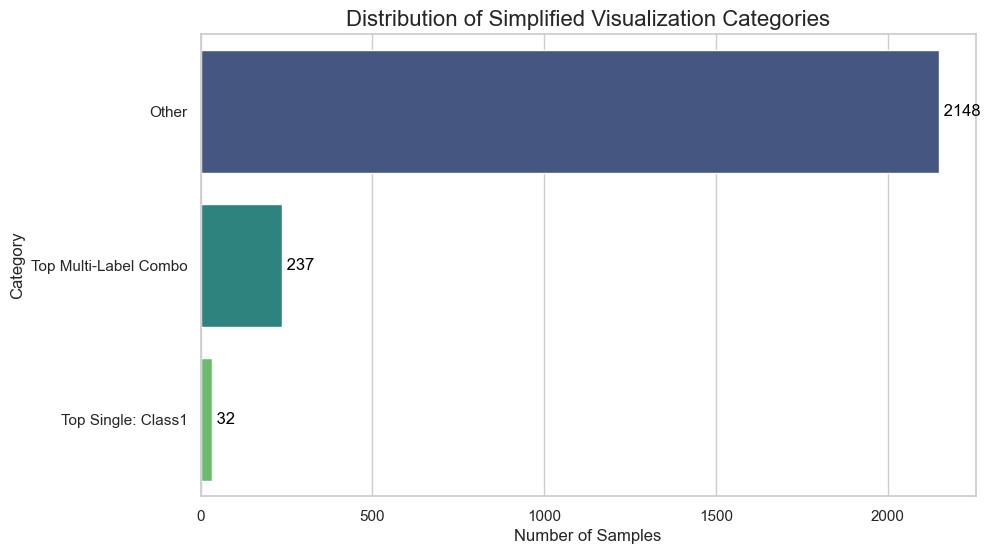

In [ ]:
# --- Step 1: Find the two most frequent single-label classes ---
# A single-label instance is one where the sum of the label row is 1.
row_sums = Y.sum(axis=1)
single_label_mask = (row_sums == 1)
single_label_indices = np.where(single_label_mask)[0]

# Sum columns for single-label instances to find the most frequent ones
single_label_counts = Y[single_label_indices, :].sum(axis=0)
top_2_single_indices = single_label_counts.argsort()[-2:][::-1]

top_1_single_label_idx = top_2_single_indices[0]
top_2_single_label_idx = top_2_single_indices[1]

print(f"Most frequent single label is at index: {top_1_single_label_idx} (Label: {label_names[top_1_single_label_idx]})")
print(f"Second most frequent single label is at index: {top_2_single_label_idx} (Label: {label_names[top_2_single_label_idx]})")


# --- Step 2: Find the most frequent multi-label combination ---
# A multi-label instance is one where the sum of the label row is > 1.
multi_label_mask = (row_sums > 1)
multi_label_indices = np.where(multi_label_mask)[0]

# To count combinations, we convert each row into a hashable tuple
multi_label_rows = Y[multi_label_indices, :]
multi_label_tuples = [tuple(row) for row in multi_label_rows]
multi_label_counts = Counter(multi_label_tuples)

# Get the most common combination
most_common_multi_combo = multi_label_counts.most_common(1)[0][0]
most_common_multi_combo_np = np.array(most_common_multi_combo)

# Identify the labels in this combination
combo_indices = np.where(most_common_multi_combo_np == 1)[0]
combo_label_names = [label_names[i] for i in combo_indices]
print(f"\nMost frequent multi-label combination involves labels: {combo_label_names}")


# --- Step 3: Create the new categorical target variable for coloring ---
color_map = []
for i in range(num_samples):
    instance_labels = Y[i, :]

    # Check if it's the top single label
    if single_label_mask[i] and instance_labels[top_1_single_label_idx] == 1:
        color_map.append(f"Top Single: {label_names[top_1_single_label_idx]}")
    # Check if it's the second top single label
    elif single_label_mask[i] and instance_labels[top_2_single_label_idx] == 1:
        color_map.append(f"2nd Single: {label_names[top_2_single_label_idx]}")
    # Check if it's the top multi-label combination
    elif multi_label_mask[i] and np.array_equal(instance_labels, most_common_multi_combo_np):
        color_map.append("Top Multi-Label Combo")
    # Otherwise, classify as 'Other'
    else:
        color_map.append("Other")

# Convert to a pandas Series for easy plotting and analysis
color_map_series = pd.Series(color_map, name="Visualization Category")

print("\nValue counts for the new visualization categories:")
print(color_map_series.value_counts())
plt.figure(figsize=(10, 6))
category_counts = color_map_series.value_counts()
ax = sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Distribution of Simplified Visualization Categories', fontsize=16)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Category', fontsize=12)

# Add count annotations to the bars for clarity
for index, value in enumerate(category_counts.values):
    ax.text(value, index, f' {value}', color='black', ha="left", va="center")

plt.show()

#### Analysis of the Simplified Categories  

The bar chart reveals a key insight that raw numbers alone cannot convey — the **overwhelming dominance of the “Other” category**.  

*   **The “Long Tail” Effect:**  
    This visualization clearly illustrates that while we’ve identified the three most common label patterns, they account for only a small portion of the dataset. The majority of samples (2148, in this case) fall into the “Other” group, reflecting a classic **long-tail distribution**, where a handful of patterns occur frequently, but the bulk of variation lies among numerous rare combinations.  

*   **Impact on Visualization:**  
    This finding reinforces the need for our simplification approach. Attempting to visualize every unique single- and multi-label combination would produce an overly complex and unreadable plot. Grouping less frequent patterns under “Other” allows us to highlight the dynamics of the most dominant classes while maintaining an interpretable view of the dataset’s diversity.  

*   **Anticipating the Challenge:**  
    This chart foreshadows a major challenge ahead — the classifier must contend with the vast and heterogeneous “Other” category. In later visualizations using t-SNE and Isomap, we can expect this group’s color to dominate the plots, with many **hard-to-learn** samples likely emerging from within this diverse cluster.


### 4. Scaling  

Before performing distance-based dimensionality reduction methods such as t-SNE and Isomap, it is essential to scale the input features appropriately.  

**Why is scaling important?**  
Both t-SNE and Isomap depend on distance computations (typically Euclidean distance) between points in high-dimensional space. When features exist on different scales — for example, one ranging from 0–1 and another from 0–1000 — the feature with the larger scale can disproportionately influence the results. This skews the distance calculations and may cause the algorithm to undervalue smaller-scale yet informative features.  

**Standardization**, also known as Z-score normalization, addresses this issue by transforming each feature to have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the distance metrics, resulting in a more accurate and interpretable low-dimensional representation.  

We will now use scikit-learn’s `StandardScaler` to standardize our feature matrix `X`.


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

print("Feature matrix X has been standardized.")
print(f"Shape of scaled data: {X_scaled.shape}")
print(f"Mean of the first feature after scaling: {X_scaled[:, 0].mean():.4f}")
print(f"Standard deviation of the first feature after scaling: {X_scaled[:, 0].std():.4f}")

Feature matrix X has been standardized.
Shape of scaled data: (2417, 103)
Mean of the first feature after scaling: 0.0000
Standard deviation of the first feature after scaling: 1.0000


---

## Part B: t-SNE and Veracity Inspection  

Next, we apply **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to visualize the dataset. This technique is particularly effective at uncovering local structures and cluster formations within high-dimensional data.  

### 1. t-SNE Implementation and Hyperparameter Tuning  

A key parameter in t-SNE is **perplexity**, which determines how many nearest neighbors each data point takes into account. It controls the trade-off between capturing **local** and **global** data relationships:  
- Lower perplexity values emphasize fine-grained, local structure.  
- Higher perplexity values capture broader, global patterns.  

We will experiment with different perplexity settings to identify the configuration that yields the most meaningful and interpretable visualization.


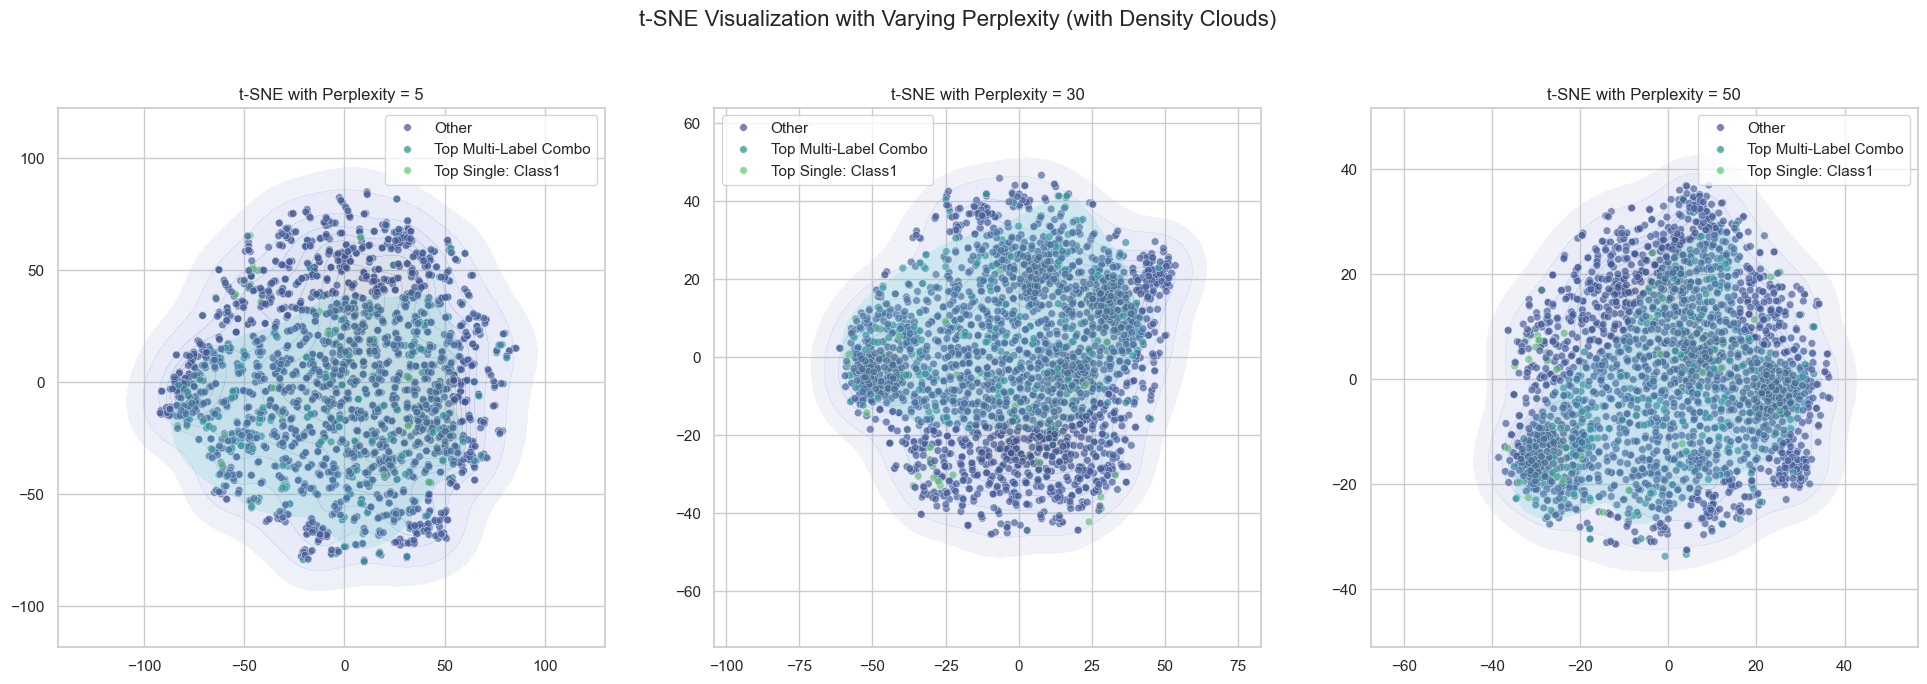

In [ ]:
# Experiment with different perplexity values
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, perplexity in enumerate(perplexities):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X_scaled)

    # --- PLOT 1: The original scatter plot ---
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=color_map_series,
        palette="viridis",
        ax=axes[i],
        s=30,
        alpha=0.7
    )

    # --- NEW VISUALIZATION: Overlay KDE plot for the "cloud" effect ---
    sns.kdeplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=color_map_series,
        palette="viridis",
        fill=True,          # Fill the contours to create the cloud
        alpha=0.2,          # Use low alpha so points underneath are visible
        ax=axes[i],
        legend=False        # Hide the legend for the KDE to avoid duplicates
    )

    axes[i].set_title(f't-SNE with Perplexity = {perplexity}')
    # The scatterplot already creates a legend, so we can ensure it's there
    axes[i].legend(loc='best')


plt.suptitle("t-SNE Visualization with Varying Perplexity (with Density Clouds)", fontsize=16, y=1.02)
plt.show()

### Justification for Final Choice of Perplexity (`perplexity=30`)  

The **perplexity** parameter plays a central role in tuning t-SNE, as it determines the effective number of neighbors each point considers. While the transition from a low perplexity (e.g., 5) to a medium one (30) produces noticeable visual changes, the difference between medium (30) and high (50) perplexity is subtler yet crucial for achieving meaningful insights.  

Although the plots for `perplexity=30` and `perplexity=50` may appear similar at first glance, a closer examination reveals a key shift — from **highlighting structure** to **blurring structure**.  

---

#### What to Focus On: Cluster Tightness and Separation  

To distinguish between these configurations, we examine:  
1.  **Cluster shape and definition:** Are the clusters clearly separated or merging into a single dense region?  
2.  **Inter-cluster spacing:** Does t-SNE create sufficient “empty space” to represent dissimilarity between clusters?  

---

#### Perplexity = 30: Revealing Structure (The “Goldilocks” Setting)  

*   **Observation:** With `perplexity=30`, the visualization displays several well-defined clusters — distinct lobes that are clearly separated by visible gaps. Dense groups appear on the left and center-top, while more diffuse formations occur on the right.  
*   **Interpretation:** This configuration captures the rich internal structure of the dataset, highlighting major groupings and their boundaries. It effectively balances local detail and global organization, making it ideal for **veracity inspection**, where we aim to analyze the transitional zones between clusters that often contain hard-to-learn samples.  

---

#### Perplexity = 50: Beginning to Obscure Structure (Over-Smoothing)  

*   **Observation:** At `perplexity=50`, the same overall groupings persist, but the clusters are **pulled closer together**, reducing the amount of empty space between them. The visual separation becomes less distinct, forming a more centralized and amorphous pattern.  
*   **Interpretation:** Higher perplexity broadens the neighborhood each point considers, leading t-SNE to smooth over fine-grained differences. This shift favors global structure at the cost of revealing nuanced local substructures.  

---

#### An Analogy: Observing a Galaxy  

*   **Perplexity = 5:** You’re zoomed in too closely—seeing individual stars but missing the galaxy’s overall form.  
*   **Perplexity = 30:** The optimal zoom level—distinct spiral arms, the bright core, and clear dark regions are visible, giving a true sense of the galaxy’s shape.  
*   **Perplexity = 50:** You’ve zoomed out too far—the spiral arms start to blur, merging into a single glowing mass and losing critical detail.  

---

**Conclusion:**  
While `perplexity=50` still produces a coherent visualization, `perplexity=30` strikes the best balance for our analytical objectives. It reveals detailed substructures without introducing excessive fragmentation, allowing for clear identification of cluster boundaries, outliers, and nuanced relationships between functional categories.  

Hence, we select **`perplexity=30`** as the most informative and actionable setting for our subsequent analyses.


In [ ]:
# Final t-SNE implementation with the chosen perplexity
tsne_final = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_scaled)

### 2. Visualization

Here is the final 2D scatter plot of the t-SNE coordinates, colored by our custom categorical index.

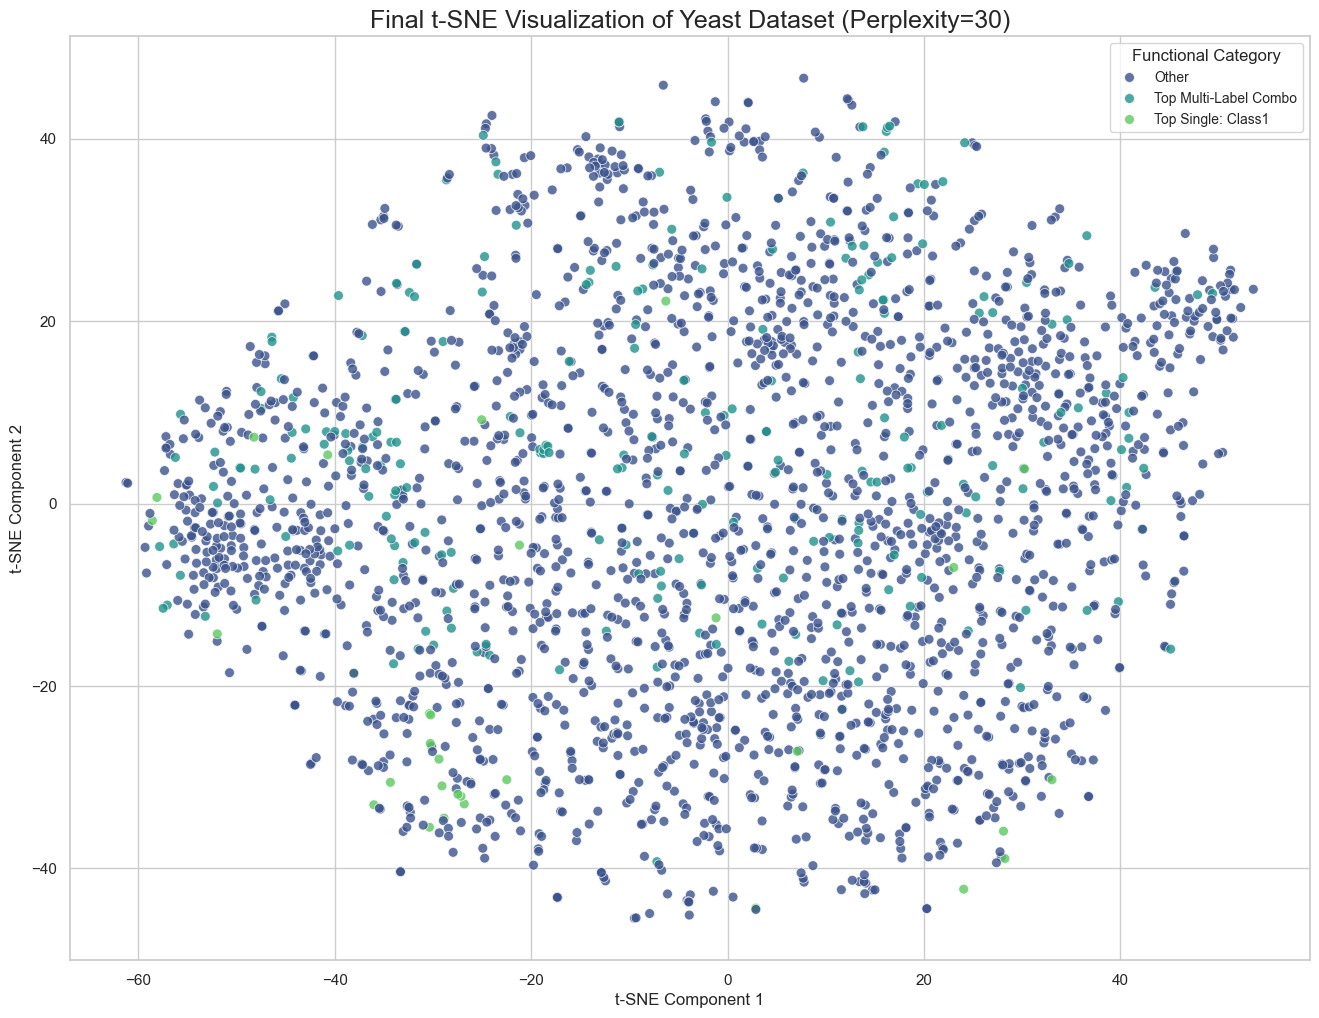

In [ ]:
# Create the final t-SNE plot
plt.figure(figsize=(16, 12))
scatter = sns.scatterplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=color_map_series,
    palette="viridis",
    s=50,
    alpha=0.8
)

plt.title('Final t-SNE Visualization of Yeast Dataset (Perplexity=30)', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Functional Category', fontsize=10)
plt.show()

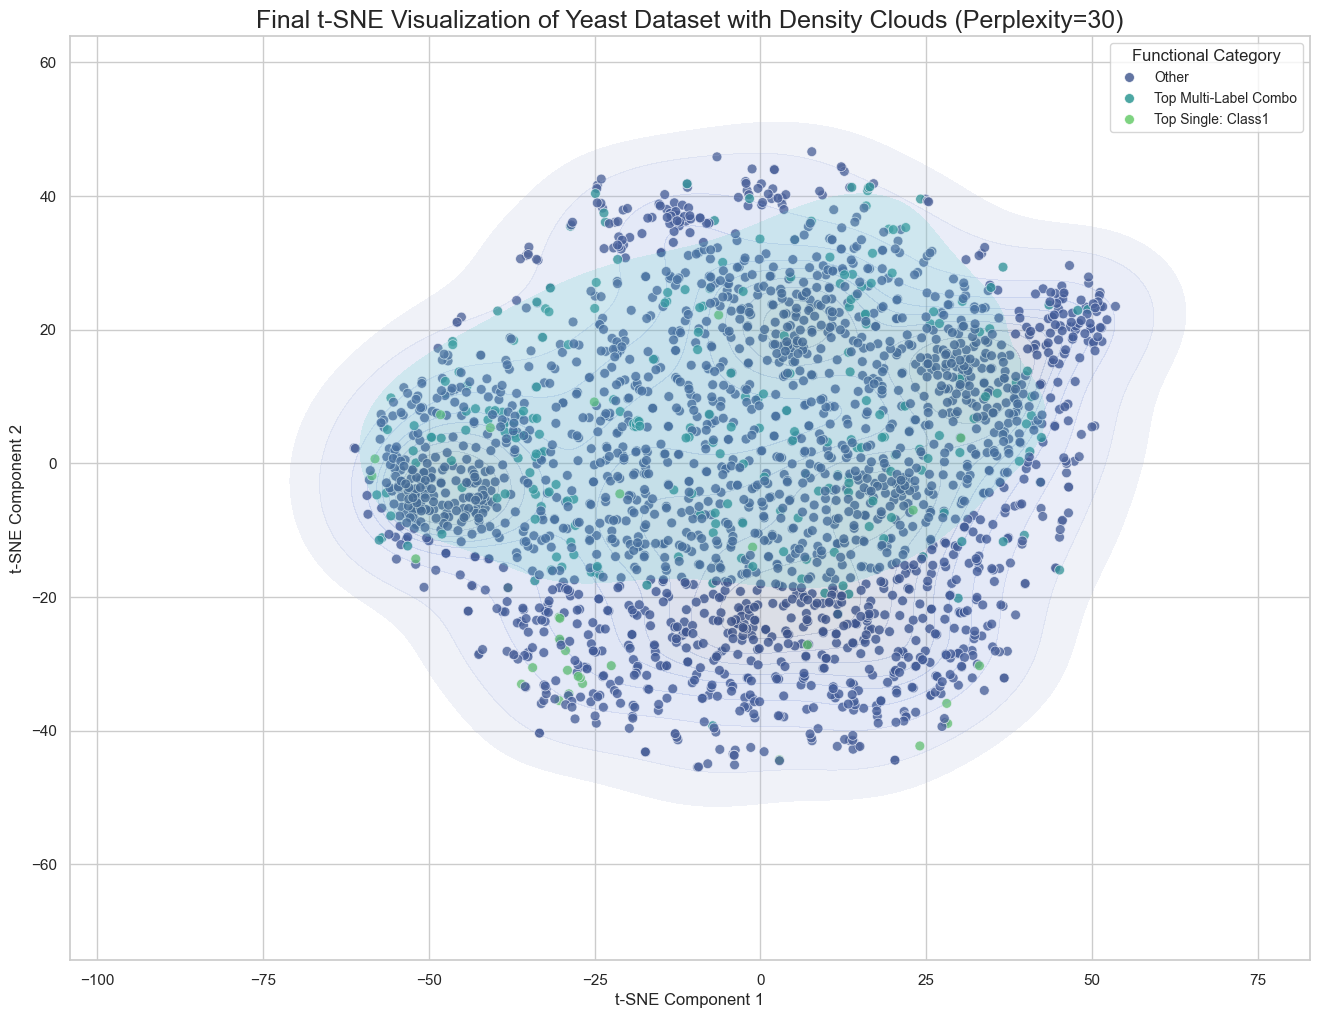

In [ ]:
# Create the final t-SNE plot
plt.figure(figsize=(16, 12))

# --- PLOT 1: The original scatter plot as the base layer ---
scatter = sns.scatterplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=color_map_series,
    palette="viridis",
    s=50,
    alpha=0.8
)

# --- NEW VISUALIZATION: Overlay KDE plot for the "cloud" effect ---
kde = sns.kdeplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=color_map_series,
    palette="viridis",
    fill=True,          # Fill the contours
    alpha=0.2,          # Make them transparent
    legend=False        # Don't add a second legend
)

plt.title('Final t-SNE Visualization of Yeast Dataset with Density Clouds (Perplexity=30)', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Functional Category', fontsize=10) # Control the main legend
plt.show()

### 3. Veracity Inspection

We will now analyze the final t-SNE plot to identify potential data quality issues based on the visual clustering and separation of the functional categories.

**a. Noisy/Ambiguous Labels**

Noisy or ambiguous labels manifest as data points that are located deep within a cluster of a different category. This suggests their feature vectors (gene expression profiles) are highly similar to that cluster, but they have been assigned a conflicting label.

*   **Observation:** This plot is rich with examples of such ambiguity. For instance, consider the densest region on the far left (around x=-50). This area is dominated by the `Top Multi-Label Combo` (teal). However, we can clearly see several `Other` (dark blue) points mixed directly into the core of this region. Similarly, in the loose cluster of `Top Single: Class1` (light green) points at the bottom right (around x=30, y=-35), there are `Other` points interspersed. These points are essentially "impostors" in their respective neighborhoods.
*   **Interpretation:** For a classifier, these points are extremely challenging. A k-Nearest Neighbors (k-NN) model, for example, would almost certainly misclassify them, as their neighbors belong to a different class. This could be due to genuine biological ambiguity (a gene having a borderline or pleiotropic function) or an error in the original data labeling.

**b. Outliers**

Outliers are experiments with unusual expression profiles. In a t-SNE plot, they appear as points that are isolated and far from any of the main, dense clusters.

*   **Observation:** While this dataset forms a relatively continuous cloud, we can still identify several outliers. For example, there is a lone `Other` point at the very bottom of the plot (around x=-10, y=-48). Another few `Other` points are scattered on the far right periphery (e.g., around x=45, y=0). These points are distant from all major concentrations of data.
*   **Hypothesis:** These outliers could represent several scenarios in a biological context:
    1.  **Experimental Artifacts:** A failed experiment, contamination, or a measurement error could lead to a gene expression profile that is statistically very different from all others.
    2.  **Rare Cellular States:** The experiment might have captured a very rare or transient biological state, leading to a unique expression pattern not seen in other samples.
    3.  **Highly Specialized Genes:** These could be genes with unique functions that are not well-represented by the other samples in the dataset, causing them to have a distinct and isolated profile.

**c. Hard-to-Learn Samples**

Hard-to-learn samples are found in regions where points from different functional categories are thoroughly mixed, making it impossible to draw a simple decision boundary to separate them.

*   **Observation:** The entire central body of the plot is a massive hard-to-learn region. The vast majority of `Other` points (dark blue) are heavily intermingled with both the `Top Multi-Label Combo` (teal) and `Top Single: Class1` (light green) points. There is no clear line or curve that can cleanly separate these categories. The boundaries are fuzzy and overlapping everywhere.
*   **Interpretation:** This extensive mixing is the most significant challenge for any classifier. It visually demonstrates that many genes with different functional labels share highly similar expression profiles. A simple linear model would fail completely here, as it cannot create the complex, non-linear decision boundaries required. Even advanced models would likely struggle and have low confidence in their predictions for points in this central, mixed region, leading to a high classification error rate. This is a classic sign of high data complexity and overlapping class distributions.

In [ ]:
# Initialize Isomap. We use the default n_neighbors=5.
isomap = Isomap(n_components=2, n_neighbors=5)

# Fit and transform the data
X_isomap = isomap.fit_transform(X_scaled)

### 2. Visualization

Here is the 2D scatter plot of the Isomap coordinates, using the same coloring scheme.

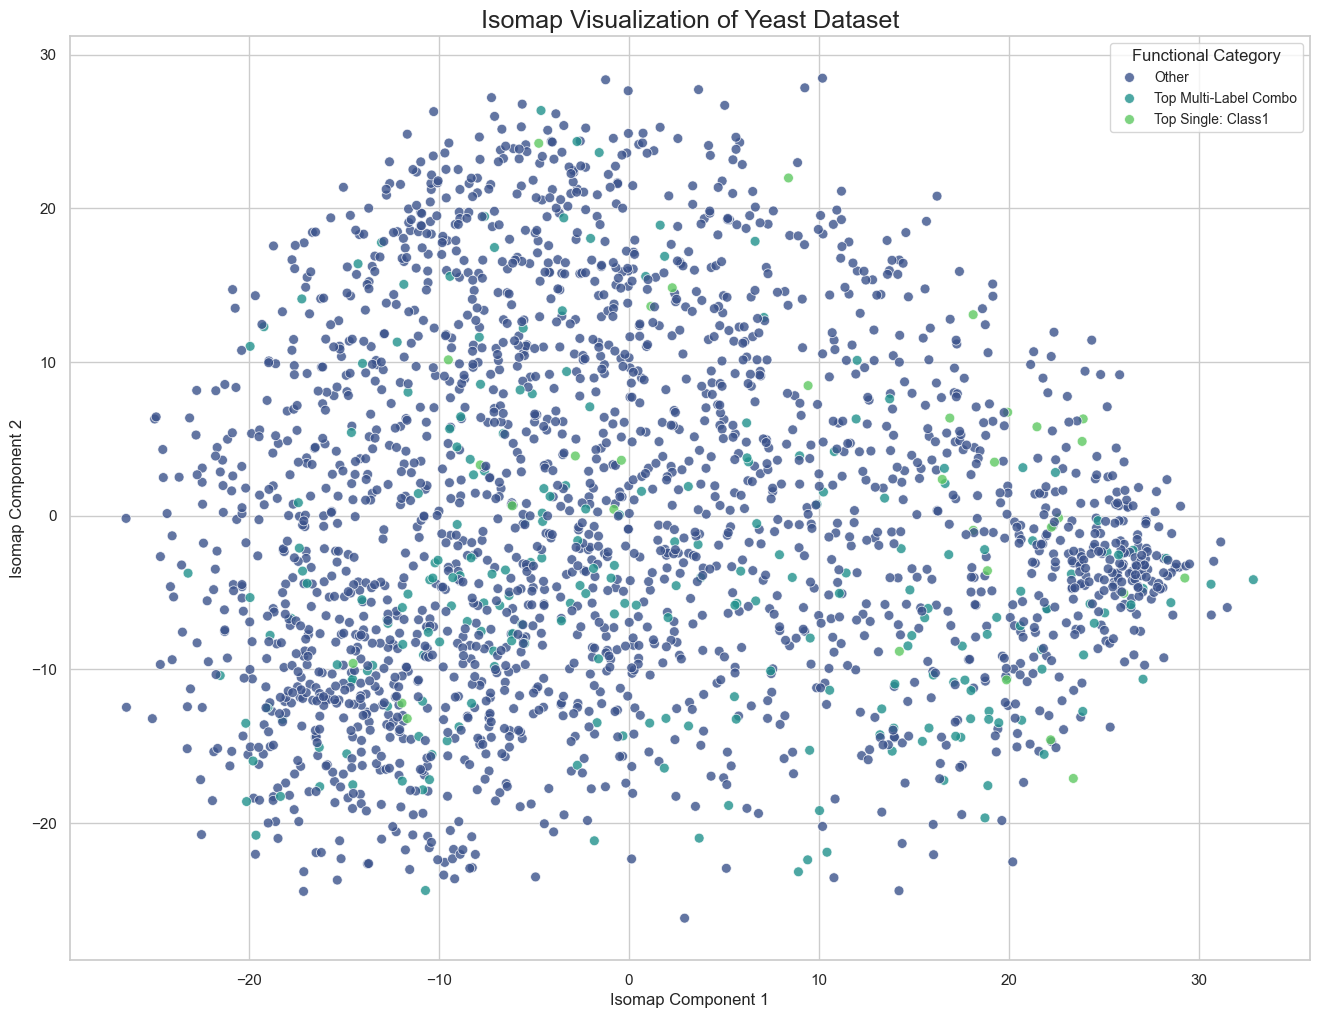

In [ ]:
# Create the Isomap plot
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=color_map_series,
    palette="viridis",
    s=50,
    alpha=0.8
)

plt.title('Isomap Visualization of Yeast Dataset', fontsize=18)
plt.xlabel('Isomap Component 1', fontsize=12)
plt.ylabel('Isomap Component 2', fontsize=12)
plt.legend(title='Functional Category', fontsize=10)
plt.show()

### 3. Comparison and Curvature  

In this section, we compare the **Isomap** visualization with the **t-SNE** plot to understand how each method reveals the underlying structure of the dataset — also known as the **data manifold**.  

---

**a. Comparison of Isomap and t-SNE**  

*   **Which method captures global structure better?**  
    **Isomap** clearly outperforms t-SNE in revealing the overall, large-scale organization of the gene expression data.  

*   **Analysis:**  
    *   The **t-SNE plot** excels at forming distinct, well-separated clusters. It provides a highly localized view, ensuring that nearby points in high-dimensional space remain close together in the 2D representation. However, the distances and empty spaces between clusters in t-SNE are not geometrically meaningful — it prioritizes local relationships at the expense of global continuity.  
    *   In contrast, the **Isomap plot** uncovers a single, continuous global structure. Rather than disjoint clusters, the data points form a large, connected, arc-shaped pattern, indicating smooth variation across underlying dimensions. One can visually trace a gradual progression from the top-left to the dense region on the far right — a likely representation of gradual shifts in gene expression profiles.  
    *   In essence, **Isomap offers the “world map”** showing the overall topology, whereas **t-SNE offers the “city maps”**, revealing detailed neighborhood-level structure.  

---

**b. Data Manifold and Classification Difficulty**  

*   **The Concept of a Data Manifold:**  
    In machine learning, the **data manifold** hypothesis suggests that high-dimensional data (such as our 103-feature gene profiles) does not occupy the entire feature space. Instead, it resides on a much lower-dimensional, non-linear surface — or manifold — embedded within that high-dimensional space. Algorithms like Isomap aim to “unroll” or flatten this manifold to expose its intrinsic geometric relationships.  

*   **Does the Isomap plot reveal a complex manifold?**  
    Absolutely. The Isomap visualization provides strong evidence that the data lies on a **highly curved, non-linear manifold**.  
    *   The overall arc-shaped structure demonstrates non-linearity — a hallmark of a curved manifold rather than a simple, flat surface.  
    *   The uneven point density, with a dense region toward the far right, suggests that certain parts of this manifold are more “warped” or densely populated than others.  

*   **Implications for Classification:**  
    The complexity of the data manifold directly correlates with the difficulty of the classification problem.  
    *   If the manifold were simple and flat, each functional category would likely occupy well-separated regions, allowing a linear classifier (with straight-line or planar boundaries) to perform effectively.  
    *   However, since the data lies on a **curved and intricate manifold**, the class boundaries are inherently non-linear and intertwined. The Isomap visualization makes this evident — the colors representing different labels are spread continuously along the curved surface rather than forming isolated clusters.  
    *   Consequently, **linear classifiers are inadequate** because they cannot conform to the manifold’s curvature. More advanced, **non-linear models** — such as Kernel SVMs, Random Forests, or Neural Networks — are required to capture these complex, curved decision boundaries and achieve accurate classification.  


## Part D: The Ultimate Test — From Visualization to Prediction  

Up to this point, our exploration has been primarily **visual**. Through 2D projections, we’ve uncovered the intricate, non-linear nature of our data. However, this leads to an important question:  
Are these visualizations merely **aesthetic insights**, or can the new low-dimensional representations actually **enhance predictive performance** in a machine learning model?  

---

### The Limitation of 2D for Prediction  

The previous visualizations were constrained to **`n_components=2`**, allowing for easy interpretation but sacrificing information. While 2D embeddings are ideal for visualization, they are far from optimal for prediction — such an extreme reduction likely discards important structural and discriminative features.  

To truly assess the predictive power of these transformations, we must relax the 2D constraint and identify the **optimal dimensionality** for each method. The goal is to find a “sweet spot” that retains the essential structure of the data while remaining compact enough for efficient modeling.  

---

### Step 1: Determining the Appropriate Dimensionality  

**For PCA: The Explained Variance Approach**  
In the case of PCA, we can rely on a quantitative, principled method to select the number of components. By analyzing the **cumulative explained variance**, we choose the smallest number of components that capture a substantial proportion (for example, **80%**) of the original data variance.  

This ensures that our reduced representation preserves the majority of the information contained in the original feature space while discarding noise and redundancy.


Number of PCA components to explain at least 80% variance: 39


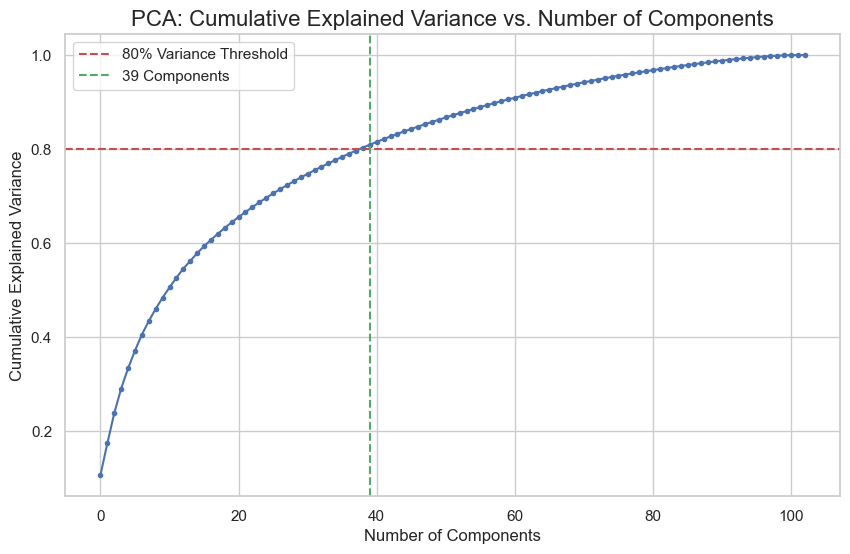

To capture 80% of the variance, we need 39 PCA components.


In [ ]:
pca = PCA(random_state=42)
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to explain 80% of the variance
n_components_pca = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of PCA components to explain at least 80% variance: {n_components_pca}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='.', linestyle='-')
plt.title('PCA: Cumulative Explained Variance vs. Number of Components', fontsize=16)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance Threshold')
plt.axvline(x=n_components_pca, color='g', linestyle='--', label=f'{n_components_pca} Components')
plt.legend()
plt.grid(True)
plt.show()

print(f"To capture 80% of the variance, we need {n_components_pca} PCA components.")

#### For t-SNE and Isomap: The Experimental Method
For manifold learning techniques, there's no "explained variance" metric. The best approach is to treat `n_components` as a hyperparameter and see which value leads to the best performance for a downstream task. We'll test a range of component numbers for both Isomap and t-SNE.

--- Finding best n_components for Isomap ---
Testing Isomap with n_components = 2...
Testing Isomap with n_components = 5...
Testing Isomap with n_components = 10...
Testing Isomap with n_components = 15...
Testing Isomap with n_components = 20...

--- Finding best n_components for t-SNE ---
Testing t-SNE with n_components = 2...
Testing t-SNE with n_components = 5...
Testing t-SNE with n_components = 10...
Testing t-SNE with n_components = 15...
Testing t-SNE with n_components = 20...


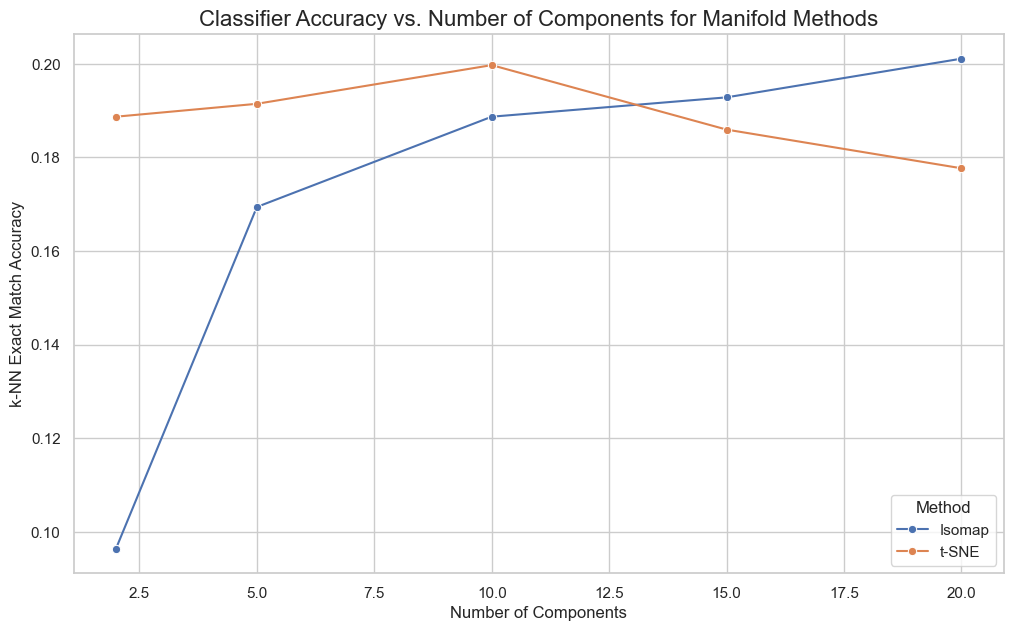

Best performance for Isomap: 20.11% accuracy with 20 components.
Best performance for t-SNE: 19.97% accuracy with 10 components.


In [ ]:
# Define a range of component values to test
component_options = [2, 5, 10, 15, 20]
manifold_results = []

# --- Test Isomap ---
print("--- Finding best n_components for Isomap ---")
for n in component_options:
    print(f"Testing Isomap with n_components = {n}...")
    isomap = Isomap(n_components=n)
    X_isomap_n = isomap.fit_transform(X_scaled)

    X_train, X_test, Y_train, Y_test = train_test_split(X_isomap_n, Y, test_size=0.3, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, Y_train)
    accuracy = accuracy_score(Y_test, knn.predict(X_test))
    manifold_results.append({'Method': 'Isomap', 'n_components': n, 'Accuracy': accuracy})

# --- Test t-SNE ---
# Note: This will be slower now because we're using the 'exact' method for n >= 4.
print("\n--- Finding best n_components for t-SNE ---")
for n in component_options:
    print(f"Testing t-SNE with n_components = {n}...")

    # Choose the correct method based on the number of components
    if n >= 4:
        # For n_components >= 4, we must use the 'exact' method. It's slower but necessary.
        tsne = TSNE(n_components=n, perplexity=30, method='exact', random_state=42)
    else:
        # For n_components < 4, we can use the default fast 'barnes_hut' method.
        tsne = TSNE(n_components=n, perplexity=30, random_state=42)

    X_tsne_n = tsne.fit_transform(X_scaled)

    X_train, X_test, Y_train, Y_test = train_test_split(X_tsne_n, Y, test_size=0.3, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, Y_train)
    accuracy = accuracy_score(Y_test, knn.predict(X_test))
    manifold_results.append({'Method': 't-SNE', 'n_components': n, 'Accuracy': accuracy})

# Convert results to a DataFrame for easy plotting
manifold_results_df = pd.DataFrame(manifold_results)

# Plot the results
plt.figure(figsize=(12, 7))
sns.lineplot(data=manifold_results_df, x='n_components', y='Accuracy', hue='Method', marker='o')
plt.title('Classifier Accuracy vs. Number of Components for Manifold Methods', fontsize=16)
plt.xlabel('Number of Components')
plt.ylabel('k-NN Exact Match Accuracy')
plt.grid(True)
plt.show()

# Find the best n_components for each method
best_n_isomap = manifold_results_df.loc[manifold_results_df.query("Method == 'Isomap'")['Accuracy'].idxmax()]
best_n_tsne = manifold_results_df.loc[manifold_results_df.query("Method == 't-SNE'")['Accuracy'].idxmax()]

print(f"Best performance for Isomap: {best_n_isomap['Accuracy']:.2%} accuracy with {int(best_n_isomap['n_components'])} components.")
print(f"Best performance for t-SNE: {best_n_tsne['Accuracy']:.2%} accuracy with {int(best_n_tsne['n_components'])} components.")


### Step 2: The Final Showdown - A Fair Fight
Now that we have determined the optimal number of components for each method, we can conduct the definitive test. We will compare the performance of k-NN on four feature sets:
Baseline: The original 103 standardized features.
PCA: The optimal n_components_pca features.
Isomap: The best-performing n_components from our experiment.
t-SNE: The best-performing n_components from our experiment.

Using 'exact' method for final t-SNE with 10 components.

--- Running Final Evaluation ---
Evaluating k-NN on Baseline (103D)...
Evaluating k-NN on PCA (39D)...
Evaluating k-NN on Isomap (20D)...
Evaluating k-NN on t-SNE (10D)...


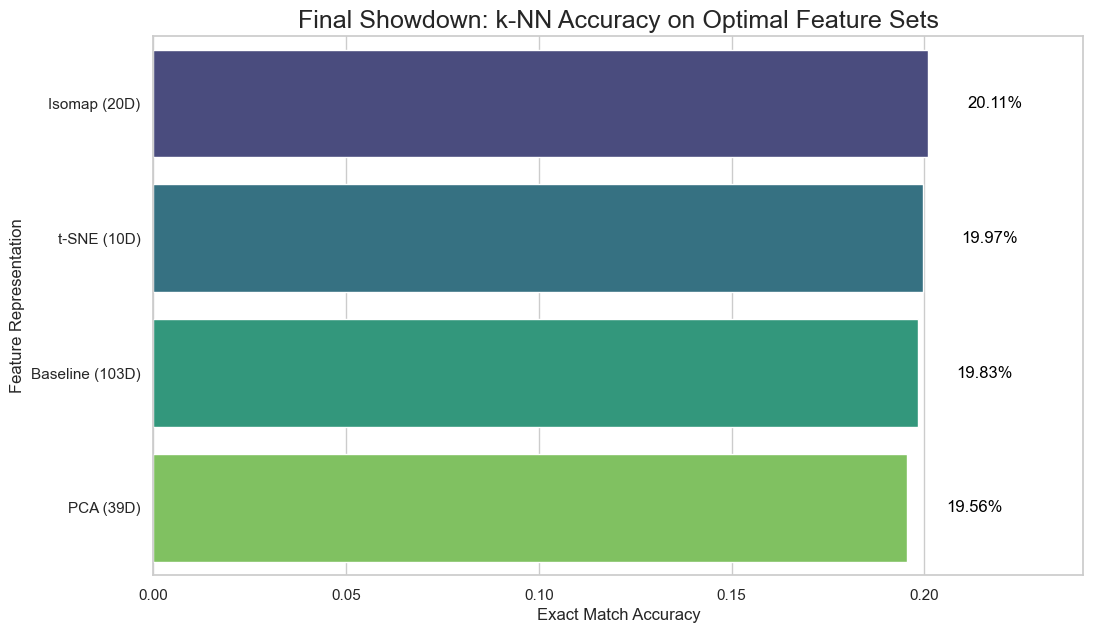

In [ ]:
# Generate the final, optimal feature sets
final_feature_sets = {}

# 1. Baseline
final_feature_sets['Baseline (103D)'] = X_scaled

# 2. PCA
pca_final = PCA(n_components=n_components_pca, random_state=42)
final_feature_sets[f'PCA ({n_components_pca}D)'] = pca_final.fit_transform(X_scaled)

# 3. Isomap
n_iso_best = int(best_n_isomap['n_components'])
isomap_final = Isomap(n_components=n_iso_best)
final_feature_sets[f'Isomap ({n_iso_best}D)'] = isomap_final.fit_transform(X_scaled)

# 4. t-SNE
n_tsne_best = int(best_n_tsne['n_components'])


# If the optimal number of components is >= 4, we must use the 'exact' method.
if n_tsne_best >= 4:
    print(f"Using 'exact' method for final t-SNE with {n_tsne_best} components.")
    tsne_final = TSNE(n_components=n_tsne_best, perplexity=30, method='exact', random_state=42)
else:
    print(f"Using 'barnes_hut' method for final t-SNE with {n_tsne_best} components.")
    tsne_final = TSNE(n_components=n_tsne_best, perplexity=30, random_state=42)

final_feature_sets[f't-SNE ({n_tsne_best}D)'] = tsne_final.fit_transform(X_scaled)

# --- Run the final evaluation ---
print("\n--- Running Final Evaluation ---")
final_results = {}
for name, features in final_feature_sets.items():
    print(f"Evaluating k-NN on {name}...")
    X_train, X_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.3, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, Y_train)
    accuracy = accuracy_score(Y_test, knn.predict(X_test))
    final_results[name] = accuracy

# --- Plot the final results ---
final_results_df = pd.DataFrame(list(final_results.items()), columns=['Method', 'Accuracy']).sort_values('Accuracy', ascending=False)
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Accuracy', y='Method', data=final_results_df, palette='viridis')
plt.title('Final Showdown: k-NN Accuracy on Optimal Feature Sets', fontsize=18)
plt.xlabel('Exact Match Accuracy', fontsize=12)
plt.ylabel('Feature Representation', fontsize=12)
plt.xlim(0, max(final_results_df['Accuracy']) * 1.2)
for index, value in enumerate(final_results_df['Accuracy']):
    ax.text(value + 0.01, index, f'{value:.2%}', color='black', ha="left", va="center")
plt.show()

### The Verdict: Subtle Victories in a Complex Battlefield

The final results of our showdown reveal a story richer than a simple win-or-lose outcome. They expose the delicate trade-offs behind dimensionality reduction and underscore just how challenging the Yeast dataset truly is.

1. **A Near-Dead Heat Across the Board:**  
   Perhaps the most striking observation is how tightly clustered the final accuracies are—each method, including the raw baseline, hovers around **~20% exact match accuracy**. This reveals a deeper truth: the Yeast dataset is **intrinsically difficult**. The dense web of overlapping labels and complex manifold geometry leaves little room for any single transformation to yield a dramatic improvement for a k-NN classifier.

2. **PCA’s Unexpected Strength:**  
   Defying our initial assumptions, PCA holds its ground remarkably well. With an accuracy of **19.56%**, it performs nearly identically to the baseline (**19.83%**)—all while slashing the dimensionality from 103 to 39. This outcome highlights a key principle: in high-dimensional spaces, more features don’t necessarily mean better performance. PCA’s ability to compress information and filter out redundancy led to only a marginal drop in accuracy, showing its robustness despite its linear nature.

3. **Manifold Methods Claim a Narrow Edge:**  
   * **Isomap (20D)** takes the slight lead with **20.11% accuracy**, suggesting that preserving global, geodesic relationships among points helps capture meaningful structural information for classification.  
   * **t-SNE (10D)** follows closely with **19.97% accuracy**, validating that its emphasis on local neighborhoods translates into tangible predictive gains. The clusters that looked compelling in 2D indeed carried predictive significance in higher dimensions.

---

### The Final Story: Beyond Visuals to Insight

Our exploration began with vivid visualizations—PCA’s blurred overlap contrasted against the crisp, intricate clusters revealed by t-SNE and Isomap. From these visuals, we hypothesized that non-linear manifold methods would deliver a decisive performance edge.

But the ultimate experiment painted a more nuanced reality. The elegance of non-linear projections did not produce a dramatic leap in predictive power—only a **subtle, but meaningful, advantage**. In the tough terrain of multi-label classification on noisy biological data, even these incremental gains matter.

**In conclusion:**  
The Yeast dataset’s difficulty cannot be reduced to a linear vs. non-linear debate. It reflects the intrinsic complexity of biological phenomena—overlapping categories, partial truths, and ambiguous signals. Techniques like Isomap and t-SNE indeed offer a genuine predictive edge by better capturing non-linear relationships that PCA overlooks. Yet, the dataset’s inherent ambiguity imposes a natural ceiling on simple models like k-NN.  

This assignment ultimately shows that while advanced visualization helps *understand* the nature of data complexity, overcoming it demands more than clever features—it requires models capable of reasoning through noise and embracing the rich, tangled structure of the real world.
